# Exp012: Train classifiers from corpus examples
This experiments uses regular expressions to identify possible positive and hard negative instances in multiple corpora. It may add handpicked generated examples if the corpus does not have enough examples.

In [1]:
import re
import os
import random
import numpy as np
from torch import tensor, Tensor
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.model_selection import KFold
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import sys
sys.path.append('../source')
import models
import data
import importlib
#importlib.reload(models)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package punkt to
[nltk_data]     /cluster/home/dglandorf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# load corpus sentences and prepare dataloader
sentences = data.get_mixed_sentences(1000000) # get all sentences

# initialize corpus to check against
max_batches = 250
batch_size = 64
encoded_inputs = models.bert_tokenizer(sentences[:12*max_batches*batch_size], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
encoded_inputs['sentences'] = sentences[:12*max_batches*batch_size]
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=64, shuffle=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.94s/it]


In [5]:
# output dataset
output_path = '../data/annotated_corpus.json'
instances = pd.DataFrame(columns=['#', 'sentence', 'positive']) if not os.path.exists(output_path) else pd.read_json(output_path)
instances['positive'] = instances['positive'].astype(bool)

egp_gpt = pd.read_json("../data/egp_gpt35.json")

In [6]:
# manipulation functions for instance dataset
def get_positives(instances, nr):
    return list(instances[(instances['#'] == nr) & instances['positive']]['sentence'])
def get_negatives(instances, nr):
    return list(instances[(instances['#'] == nr) & ~instances['positive']]['sentence'])
def get_others(sentences, matches):
    return list(set(sentences).difference(set(matches)))
def add_to_instances(sentences, nr, positive=True):
    global instances
    if isinstance(sentences, list):
        for sentence in sentences:
            new_row = pd.DataFrame({'#': [nr], 'sentence': [sentence], 'positive': [positive]})
            instances = pd.concat([instances, new_row], ignore_index=True)
    else:
        new_row = pd.DataFrame({'#': [nr], 'sentence': [sentences], 'positive': [positive]})
        instances = pd.concat([instances, new_row], ignore_index=True)
    instances.to_json(output_path)

# model training
def get_trained_classifer(positive, negative, others, classifier=models.RuleDetector(models.bert_encoder).to(models.device), ratio=1, verbose=True):
    dataset = data.get_dataset(positive, negative, others, models.bert_tokenizer, 64, ratio*len(positive)/len(negative), verbose=verbose) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=verbose)
    return classifier, val_metrics

Find examples for would rules (616-638), conditionals (1105-1131), negations (1175-1205)

In [185]:
nr = 1204

In [191]:
pattern = r"(neither|nor) (do|did|does|am|are|is|was|were) "
matches = [sentence for sentence in sentences if re.search(pattern, sentence, re.IGNORECASE)]
random.shuffle(matches)
candidates = iter(matches)

In [209]:
gpt35 = egp_gpt[egp_gpt['#']==nr].iloc[0]
egp_matches = gpt35['augmented_examples']
random.shuffle(egp_matches)
candidates = iter(egp_matches)

In [198]:
anti_pattern =  r"( neither| nor) "
anti_matches = [sentence for sentence in sentences if re.search(anti_pattern, sentence, re.IGNORECASE)]
random.shuffle(anti_matches)
candidates = iter(anti_matches)

In [181]:
candidates = iter(subset_sentences)

In [200]:
candidates = iter(get_positives(instances, 1194))

In [98]:
len(instances)

9543

In [210]:
while 1==1:
    if len(get_positives(instances, nr)) == 50: print("** REACHED 50 POSITIVES **")
    try:
        candidate = next(candidates)
    except StopIteration:
        print("No candidates left.")
        break
    if candidate in list(instances[instances['#'] == nr]['sentence']): continue # prevent duplicates
    #candidate = candidate.replace(",", "")
    user_response = input(f"{candidate}")
    if user_response == "c": break
    if user_response == "s": continue
    if user_response == "del": 
        instances = instances.iloc[:-1]
        continue
    new_row = pd.DataFrame({'#': [nr], 'sentence': [candidate], 'positive': [True if user_response == '2' else False]})
    instances = pd.concat([instances, new_row], ignore_index=True)
    instances.to_json(output_path)

She didn't mention the additional expenses, nor did she provide a breakdown of the costs incurred. 2
Their lack of transparency raised suspicion. Nor did their evasive answers instill confidence. 2
The investment didn't generate profits, nor did it provide any long-term benefits.  2
I haven't been to the theater in months. Nor have I watched a movie at home. 2
He didn't attend the presentation, neither did he review the slides beforehand. 2
We can't meet on Monday. Nor can we schedule a meeting for Tuesday. 2
We don't have any plans for the weekend. Neither do our neighbors. 2
They couldn't arrive on time, nor could they leave early. 2
He didn't pass the exam, neither did he seek help from a tutor. 2
He didn't buy the new phone. Nor did he upgrade his laptop. s
She doesn't like spicy food, nor does her sister. 2
He didn't bother to listen to my warnings. Nor did he take any precautions to prevent the impending disaster. s
I didn't hear about the last-minute changes. Neither did I recei

In [211]:
print(f'Positive: {len(get_positives(instances, nr))}, Negative: {len(get_negatives(instances, nr))}')

Positive: 48, Negative: 40


In [212]:
classifier, val_metrics = get_trained_classifer(get_positives(instances, nr), get_negatives(instances, nr), get_others(sentences, matches), ratio=3)
val_metrics

0.20689655172413793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.98it/s]


Training loss: 0.026932634102801483
Val loss: 0.00972157868091017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 20.53it/s]


Training loss: 0.024555387751509745
Val loss: 0.0066351593704894185


{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0}

Check on entire corpus

In [204]:
# shuffle inputs
shuffled_index = np.random.permutation(encoded_inputs['input_ids'].size(0))
for key, value in encoded_inputs.items():
    encoded_inputs[key] = value[shuffled_index] if isinstance(value, Tensor) else [value[i] for i in shuffled_index]

corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=64, shuffle=False)
scores, tokens = models.score_corpus(classifier, corpus_dataloader, max_positive=50, max_batches=500, threshold=0.5)
results = list(zip(scores, tokens, encoded_inputs['sentences'][:len(scores)]))

 17%|█████████████████▋                                                                                        | 500/3000 [00:41<03:28, 11.98it/s]


In [205]:
threshold = 0.5

subset = [(score, token, sample) for score, token, sample in results if
     score > threshold and not sample in get_positives(instances, nr)]
subset_sentences = [sample for _, _, sample in subset if not "don't you" in sample.lower()]
candidates = iter(subset_sentences) 
subset_sentences

['Never should you interrupt on a unfamiliar topic.',
 'So would i. what other unusual plants did they show?',
 'So did I. I won a prize last week but it was a prize for beginners.',
 'Not every one is motivated solely by money.',
 'So do I. Daniel looked so good on paper.',
 'Not to mention serious lapses in service, sales and leadership skills.',
 'So are you.',
 "so do i. I don't like cats.",
 "And not another shout or I'll have to report you to the school administration.",
 'So are we.',
 'Not all states have an income tax.',
 'So would i. what other unusual plants did they show?']

In [178]:
#add_to_instances(gpt35['augmented_examples'][100:150], nr, True)
#add_to_instances(random.sample(subset_sentences, 25), nr, False)
add_to_instances(subset_sentences, nr, False)
#add_to_instances(random.sample(get_positives(instances, 619), 50), nr, False)
#add_to_instances(list(set(get_positives(instances, 621)).difference(get_negatives(instances, nr))), nr, False)
classifier, metrics = get_trained_classifer(get_positives(instances, nr), get_negatives(instances, nr), get_others(sentences, matches), ratio=0.5)
metrics

0.19858156028368795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.62it/s]


Training loss: 0.20056423731148243
Val loss: 0.1889430731534958


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.14it/s]


Training loss: 0.12380914855748415
Val loss: 0.1368415355682373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.57it/s]


Training loss: 0.07106909342110157
Val loss: 0.059711702167987823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.55it/s]


Training loss: 0.046755827497690916
Val loss: 0.06455478817224503


{'accuracy': 0.966, 'f1': 0.933, 'precision': 0.875}

In [218]:
models.save_classifier(classifier, nr, "corpus_training")

In [287]:
nr=1106
classifier = models.load_classifier(nr, "corpus_training")

In [217]:
candidates = gpt35['Example'].split("\n\n") + ["Unfortunately, did the house convince me do move in with her parents."]
models.probe_model(classifier, candidates)

(tensor([0.9856, 0.9956, 0.0023]), ['nor', 'neither', ','])

## Evaluation
Strategy: Track F1 score on validation set and precision in unseen corpora sentences

In [49]:
total_folds = 5
batch_size = 32
metrics = {}

for nr in range(616, 639):
    print(f'#{nr}')
    pos = get_positives(instances, nr)
    neg = get_negatives(instances, nr)
    dataset = data.get_dataset(pos, neg, get_others(sentences, pos), models.bert_tokenizer, 64, 2*len(pos)/len(neg))
    indices = list(range(len(dataset)))
    kf = KFold(n_splits=total_folds, shuffle=True, random_state=26)
    accumulated_metrics = defaultdict(list)
    for fold_index in tqdm(range(total_folds)):
        train_indices, val_indices = list(kf.split(indices))[fold_index]
        train_dataloader = DataLoader(Subset(dataset, train_indices), batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False)
    
        classifier=models.RuleDetector(models.bert_encoder).to(models.device)
        _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=False)
        if val_metrics['precision'] < 0.5: # try again in those extreme cases
            _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=False)
        for metric_name, metric_value in val_metrics.items():
            accumulated_metrics[metric_name].append(metric_value)
    
    average_metrics = {metric_name: sum(metric_values) / len(metric_values) for metric_name, metric_values in accumulated_metrics.items()}
    metrics[nr] = average_metrics
    print(average_metrics)

#616


100%|████| 5/5 [00:28<00:00,  5.68s/it]


{'accuracy': 0.9014000000000001, 'f1': 0.7114, 'precision': 0.8248}
#617


100%|████| 5/5 [00:19<00:00,  3.80s/it]


{'accuracy': 0.9322000000000001, 'f1': 0.8146000000000001, 'precision': 0.837}
#618


100%|████| 5/5 [00:20<00:00,  4.08s/it]


{'accuracy': 0.9209999999999999, 'f1': 0.8384, 'precision': 0.774}
#619


100%|████| 5/5 [00:22<00:00,  4.45s/it]


{'accuracy': 0.8934, 'f1': 0.7674, 'precision': 0.8492}
#620


100%|████| 5/5 [00:38<00:00,  7.70s/it]


{'accuracy': 0.9614, 'f1': 0.7769999999999999, 'precision': 0.7778}
#621


100%|████| 5/5 [00:24<00:00,  4.94s/it]


{'accuracy': 0.893, 'f1': 0.5352, 'precision': 0.495}
#622


100%|████| 5/5 [00:42<00:00,  8.46s/it]


{'accuracy': 0.9593999999999999, 'f1': 0.7286, 'precision': 0.8128}
#623


100%|████| 5/5 [00:13<00:00,  2.73s/it]


{'accuracy': 0.8632000000000002, 'f1': 0.0, 'precision': 0.0}
#624


100%|████| 5/5 [00:24<00:00,  4.88s/it]


{'accuracy': 0.9446, 'f1': 0.8385999999999999, 'precision': 0.9246000000000001}
#625


100%|████| 5/5 [00:27<00:00,  5.44s/it]


{'accuracy': 0.899, 'f1': 0.6748000000000001, 'precision': 0.7834}
#626


100%|████| 5/5 [00:21<00:00,  4.36s/it]


{'accuracy': 0.9541999999999999, 'f1': 0.9203999999999999, 'precision': 0.8686}
#627


100%|████| 5/5 [00:27<00:00,  5.45s/it]


{'accuracy': 0.9452, 'f1': 0.8555999999999999, 'precision': 0.8484}
#628


100%|████| 5/5 [00:53<00:00, 10.80s/it]


{'accuracy': 0.9644, 'f1': 0.8550000000000001, 'precision': 0.9182}
#629


100%|████| 5/5 [00:32<00:00,  6.60s/it]


{'accuracy': 0.8583999999999999, 'f1': 0.2692, 'precision': 0.2666}
#630


100%|████| 5/5 [00:56<00:00, 11.20s/it]


{'accuracy': 0.9798, 'f1': 0.9582, 'precision': 0.9366000000000001}
#631


100%|████| 5/5 [00:30<00:00,  6.17s/it]


{'accuracy': 0.9645999999999999, 'f1': 0.9235999999999999, 'precision': 0.9151999999999999}
#632


100%|████| 5/5 [00:21<00:00,  4.34s/it]


{'accuracy': 0.9464, 'f1': 0.9057999999999999, 'precision': 0.8538}
#633


100%|████| 5/5 [00:21<00:00,  4.36s/it]


{'accuracy': 0.9433999999999999, 'f1': 0.8644000000000001, 'precision': 0.837}
#634


100%|████| 5/5 [00:21<00:00,  4.27s/it]


{'accuracy': 0.9018, 'f1': 0.6792, 'precision': 0.7788}
#635


100%|████| 5/5 [00:23<00:00,  4.67s/it]


{'accuracy': 0.9117999999999998, 'f1': 0.7232, 'precision': 0.8846}
#636


100%|████| 5/5 [00:42<00:00,  8.48s/it]


{'accuracy': 0.9856, 'f1': 0.969, 'precision': 0.9794}
#637


100%|████| 5/5 [00:38<00:00,  7.76s/it]


{'accuracy': 0.914, 'f1': 0.7502000000000001, 'precision': 0.8468}
#638


100%|████| 5/5 [00:23<00:00,  4.65s/it]

{'accuracy': 0.8794000000000001, 'f1': 0.0, 'precision': 0.0}


In [46]:
hits_path = '../data/corpus_training_hits.json'
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(hits_path) else pd.read_json(output_path)
coded_instances['correct'] = coded_instances['correct'].astype(bool)

for nr in range(616, 639):
    rule = egp_gpt[egp_gpt['#']==nr].iloc[0]
    if len(coded_instances[coded_instances['#']==nr]) >= 20: continue
    print(f"#{nr}: {rule['type']}: {rule['Can-do statement']} ({rule['SuperCategory']}: {rule['SubCategory']})")
    print(rule['Example'])
    classifier = models.load_classifier(nr, "corpus_training")
    scores, tokens = models.score_corpus(classifier, corpus_dataloader, max_positive=25, max_batches=1000)
    unseen_hits = [(score, token, sample) for score, token, sample in zip(scores, tokens, encoded_inputs['sentences'][:len(scores)]) if score > 0.5 and not sample in get_positives(instances, nr)]
    for score, token, sample in unseen_hits[:20]:
        if sample in list(coded_instances[coded_instances['#']==nr]['sentence']): continue
        user_response = input(f"{sample}")
        new_row = pd.DataFrame({'#': [nr],
             'sentence': [sample],
             'correct': [True if user_response == '2' else False],
             'score': [score],
             'max_token': [token]})
        coded_instances = pd.concat([coded_instances, new_row], ignore_index=True)
        coded_instances.to_json(output_path)

#627: FORM: Can use 'would not have' + '-ed' or 'wouldn’t have' + '-ed' (MODALITY: would)
Without your help, I wouldn't have got this result. 

Had it not been for that day, she would not have met George.


 33%|▎| 1000/3000 [01:22<02:44, 12.14it


You're right.If I were the teacher, I wouldn't have done that. 2
and I didn't want to be difficult about just few minutes, if I hadn't been missing the bus and in the traffic I wouldn't have been so late. 2
If you'd kept quite this would never have happened. 1
We wouldn't even have met if I hadn't been in that car accident ten years ago! 2


#629: FORM: Can use an limited range of adverbs with 'would', including 'really', 'probably', 'certainly', 'definitely'.► adverbs (MODALITY: would)
I hope you will come soon, and I think that you would really enjoy it because is something different of what you are used to. 

More over in my opinion it would probably be the best idea to choose the biggest school ... 

I would definitely choose to live by the sea side!


 16%|▏| 483/3000 [00:39<03:23, 12.35it/


I would think this was the least they could do. 1
The air would certainly be cleaner if there were fewer cars being used in the city. 2
This way we will both have money to take a cab home, otherwise, you would probably have to walk. 2
That would probably be uncomfortable. 2
Well, I guess I could give you one more chance, but this is the last time.In themeantime, I hear that Tom who normally does night shift is taking three weeks ' vacation, Can you think of anyone who would be willing to work nights while he is gone? 1
Maybe that's true for some positions, but I think the marketing and sales staff would definitely not agree. 2
And if they are seriously considering hiring you, they will probably want to know when you would be available to start work. 1
He might really appreciate that. 1
It would probably be more comfortable over there. 2
Flexibility would certainly rank high in this type of job. 2
But I would definitely recommend this place! 2
About freezing point, I think.But the morni

#630: USE: Can use 'would' to talk about the future in the past. (MODALITY: would)
I've just bought a new dress, and a beautiful black T-shirt. When I saw them, I thought they would be great for tonight's party. 

… we thought that the film would be horrible because of the title but when the film started, the story was beautiful and Mauricio and I liked it a lot. 

And she asked me if I would play the game with her against her cousin and her friend on Saturday.


  8%| | 244/3000 [00:19<03:42, 12.39it/


Stephany said she would go out with me. 2
No, I thought that would be included in the rent. 2
The problem, however, is that I can't be confident in giving you a good priceless I am confident your product will last. 1
I was hoping you would come. 2
I knew it would be colder here, but I thought there would be a lot of snow. 2
When you told your mom you would be home around 2 am, She must have a cow! 2
He began to be interested in finance because he thought he would be able to inherit the family's fortune. 2
Did she tell you whether you would get the job? 2
He said he would like to be our tour director and he lined up many things to do. 1
When she told me that she would marry no man but Dick, my heart was almost in my mouth. 2
If I won the lottery, I would buy two tickets for a trip around the world. 1
I would pick the best one. 1
I would have to weigh it to see how much it would cost. 1
It's as if he knew that my old iron would soon stop working! 2
The dressmakers said that is would be r

#631: USE: Can use 'would' to talk about imagined situations in the past. ► conditionals (MODALITY: would)
The next week I would have flown to Miami to meet George Clooney. 

If I were in your shoes I would have chosen the school which is in the centre of town…  

If you hadn't helped me, I wouldn't have known how to do that homework project. 

If I had gone with uncomfortable shoes, I wouldn't have danced all the time.


 16%|▏| 471/3000 [00:38<03:24, 12.34it/


Without her support and encouragement, I don't think I would have felt confident enough to have written up a proposal suggesting that the department change a process that had been in place for a long time. 2
I knew it would be colder here, but I thought there would be a lot of snow. 1
He began to be interested in finance because he thought he would be able to inherit the family's fortune. 1
If I were a manager, I would have a private talk with this employ to figure out the reasons. 1
If I had drunk enough and I would have had the bold to punch him in the face. 2
I thought his race would have kept him from winning. 2
If I were in your position, I wouldn't give up an inch. 1
I was caught in the heavy rain, or I would have come earlier. 2
I want the degree, so I wouldn't have accepted the offer. 2
I would have thought you were too young. 2
If you would not have been so kind, I would not have been able to pick my parents from the airport. 2
I would have been very disappointed if I hadn't g

#635: USE: Can use the negative forms of 'would' to talk about willingness in the past. (MODALITY: would)
We had to leave without you because the bus driver wouldn't wait. 

[talking about a guitar] It was all that I wanted in life but my parents would not allow me to buy it.


 33%|▎| 1000/3000 [01:22<02:44, 12.15it


He wouldn't tell me anything without a signed contract. 2
Well, the bartender wouldn't give me the pitcher of beer. 2
well, i wanted to get a pet that wouldn't disturb the neighbors. 2
Didn't I tell you over and over again that you wouldn't be able to climb the mountain unless you got enough sleep? 1
It seems that yesterday the Mexican government declared wouldn't pay back the loans it got from the World Bank.The government declared a default on the loans. 2
I wish the teacher wouldn't make us read this book. 1
The officer wouldn't lie about that. 2
Theaters wouldn't let kids in to PG moves without a parent. 2
But they wouldn't lay you off! 1
He wouldn't stop talking throughout the class. 2
It wouldn't rain in the middle of the summer. 1


#636: USE: Can use 'would' to talk about habitual actions and events in the past. (MODALITY: would)
[talking about a job that the speaker did last year] In my opinion I worked very hard. I would spend a lot of hours at work. 

[from a story about pirates] At night they would go to the rocky seaside and light a fire in order to deceive the boats and let them crash on the rocks.


 33%|▎| 1000/3000 [01:22<02:45, 12.10it


I would banish nightingales from her garden before they interrupted her song. 2
She liked to name-drop... we would be in a meeting and she would say, yesterday I was chatting with Tom. 2
When I first got here, I'd get depressed and nostalgic for anything that reminded me of home. 2
She would never talk about me behind my back or hold a grudge. 1
I would get Fuji 200 film for taking photos of natural beauty. 1
Sometimes he would wake up covered in sweat, with his legs pumping away. 2
I would have a few vases on the mantel piece and some pictures of my family on the walls, but other than that, most things would be kept in closets. 2
I could then send an e-mail to all the staff to explain the coming meeting.This way the meetings would become more focused, and people would prepare better. 1
She would be laughing one moment, and if I said something insensitive, she would start crying. 2
He lives nearby and he would just glance at the newspaper headlines, read the political sections and retu

#637: FORM: Can use an increasing range of adverbs with 'would', including 'strongly', 'easily', 'especially', 'actually', 'absolutely', 'gladly'  ► adverbs (MODALITY: would)
Considering the aspects of our education system, and the results of my research, I would strongly recommend the following changes to be made. 

Because of her wide and excellent experience with small children I believe that Nascha would easily fit into a family with small children.


 18%|▏| 526/3000 [00:42<03:21, 12.30it/


I would always be ready to go shopping with you! 2
They're absolutely right to get a replacement for 21. 1
It drives me crazy after forty minutes.And anyhow, if we go to the Latin Club you could actually learn some Latin dance steps.At the New Bar you'll just shake yourself around for an hour.And then you'll get sick of stand you'll want to go get drunk somewhere where the drinks are cheaper. 2
If you find this person is more and more important to you and you can totally trust her, then you can stay in love. 1
That would really help me, Sue. 1
I'd strongly recommend that you wait for a while before going swimming. 2
You can greatly improve your grades by always reflecting on what you can improve on. 1
He might really appreciate that. 1
If you have made progress, we will certainly raise your salary. 1
Flexibility would certainly rank high in this type of job. 1
So would you say if things don't go your way at work it could easily get you down? 1
The needles are very thin, and as long as 

#638: FORM: Can use a wide range of adverbs with 'would', including 'undoubtedly', 'possibly', 'normally', 'personally', 'eventually', 'obviously', 'significantly', 'inevitably'. ► adverbs (MODALITY: would)
[talking about the construction of a leisure centre] I believe that the construction of such a centre would undoubtedly contribute to the improvement of our quality of life. 

Organising family-oriented activities would significantly increase membership and raise the society's popularity with the local community.


 33%|▎| 1000/3000 [01:22<02:44, 12.16it


Normally, I would take you up on that suggestion, but just the champagne will do for tonight. 1
We could potentially make this tragedy work for us and make us think outside the box. 1


In [116]:
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(hits_path) else pd.read_json(hits_path)
coded_instances['correct'] = coded_instances['correct'].astype(bool)

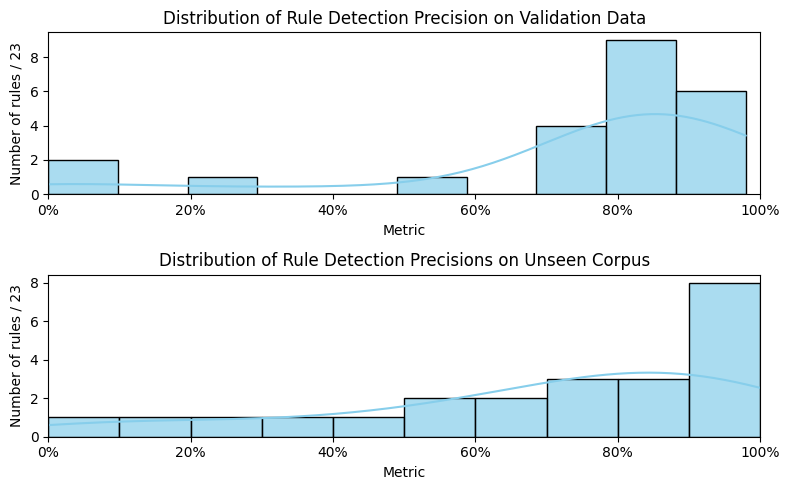

In [50]:
correct_per_rule = coded_instances.groupby('#')['correct'].mean()
def plot_histogram(ax, data):
    sns.histplot(ax=ax, data=data, bins=10, kde=True, color="skyblue", edgecolor='black', alpha=0.7, legend=False)
    ax.set_ylabel(f"Number of rules / {len(correct_per_rule)}")
    ax.set_xlabel("Metric")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.set_xlim(0, 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 5))
plot_histogram(axs[0], [m['precision'] for m in metrics.values()])
axs[0].set_title("Distribution of Rule Detection Precision on Validation Data")
plot_histogram(axs[1], list(correct_per_rule))
axs[1].set_title("Distribution of Rule Detection Precisions on Unseen Corpus")
plt.tight_layout()
plt.show()

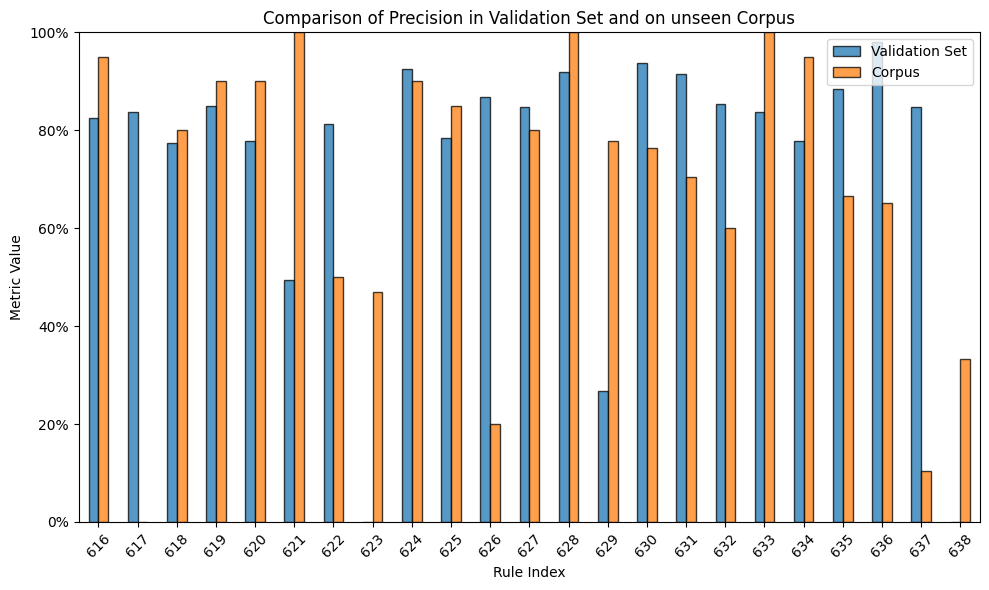

In [51]:
df = pd.DataFrame({'Validation Set': [m['precision'] for m in metrics.values()], 'Corpus': list(correct_per_rule)})
ax = df.plot(kind='bar', figsize=(10, 6), alpha=0.75, edgecolor='black')
ax.set_xlabel("Rule Index")
ax.set_ylabel("Metric Value")
ax.set_title("Comparison of Precision in Validation Set and on unseen Corpus")
ax.set_xticklabels(correct_per_rule.index, rotation=45)
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

plt.tight_layout()
plt.show()